# Diabetes risk factors
(Mathematical Statistics Homework Project)

**Viktória Nemkin (M8GXSS)**

I am interested in medical research, so I have chosen the [Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) from Kaggle as the topic of my homework project. The goal of this dataset is to predict whether someone will develop diabetes, based on key indicators of the disease.

## Input data

The dataset is anonymised and contains the following data about 100,000 individuals:

- **Age**: Ranges from 0-80, diabetes is more common amongst older adults.
- **Gender**: Can also have an impact on a person's susceptibility.
- **Body Mass Index (BMI)**: Higher BMI values are linked to higher diabetes risk.
- **Hypertension**: Presistently elevated blood pressure in the arteries, linked to heart disease.
- **Heart disease**: Associated with a risk of developing diabetes.
- **Smoking history**: Considered as a risk factor, can worsen the complications of diabetes.
- **HbA1c level**: Hemoglobin A1c, measures blood sugar level over the past 2-3 months. Over 6.5% indicates diabetes.
- **Blood glucose level**: Key indicator of diabetes.
- **Diabetes**: Target value.

These are some of the key indicators of diabetes, along with demographic data, which could be used to determine risk factors for developing diabetes.

While it is not explicitly stated, I believe the data is on Type 2 diabetes, since Type 1 is a genetic condition.

## Tools

I used Python, the `numpy` and `pandas` libraries for manipulation of the dataset, `matplotlib` and `seaborn` for plotting and visualising and `scipy` and `scikit-learn` for the various statistical analysis and evaluation tools they offer.

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency

## Data cleaning and sanity checks

The first step in working with data is making sure it is not flawed. There
is no single method that we can follow and guarantee no issues persist, but essentially
we need to be careful and thourough and make sure nothing weird is happening in the dataset.

First, I read in the dataset from the csv file.

In [156]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


I like check the value ranges for the data and make sure, that the columns are correctly typed:

In [157]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

We can use the describe method to check the value ranges of the columns:

In [158]:
df.describe(include='all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


This shows, that `gender` and `smoking_history` are actually categorical columns (they have a few unique values), while `hypertension`, `heart_disease`, and `diabetes` are meant to be boolean, and finally `age` should be an integer.

In [159]:
df['age'] = df['age'].astype(int)
df['gender'] = df['gender'].astype('category')
df['smoking_history'] = df['smoking_history'].astype('category')
df['hypertension'] = df['hypertension'].astype(bool)
df['heart_disease'] = df['heart_disease'].astype(bool)
df['diabetes'] = df['diabetes'].astype(bool)

df.dtypes

gender                 category
age                       int32
hypertension               bool
heart_disease              bool
smoking_history        category
bmi                     float64
HbA1c_level             float64
blood_glucose_level       int64
diabetes                   bool
dtype: object

Let's check our categorical values:

In [160]:
columns = df.select_dtypes(include='category').columns.tolist()

for column in columns:
    values = sorted(list(df[column].unique()))
    print(column)
    print(values)
    print()

gender
['Female', 'Male', 'Other']

smoking_history
['No Info', 'current', 'ever', 'former', 'never', 'not current']



I would like to fix the inconsistent values in `smoking_history`:

In [161]:
df['smoking_history'] = df['smoking_history'].replace({'No Info': 'no_info', 'not current': 'not_current'})

columns = df.select_dtypes(include='category').columns.tolist()

for column in columns:
    values = sorted(list(df[column].unique()))
    print(column)
    print(values)
    print()

gender
['Female', 'Male', 'Other']

smoking_history
['current', 'ever', 'former', 'never', 'no_info', 'not_current']



### Analising the column values and their distribution

When our data comes from a third party, and we have not collected it ourselves, it is a good idea to check for any inconsistencies in the values.

First, I checked that no values were missing.

In [162]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

If there were missing values, we could drop them with `df.dropna(inplace=True)`, but it is not needed.

#### BMI

The first weirdness I noticed was with BMI.

Let us plot the values of BMI in a histogram:

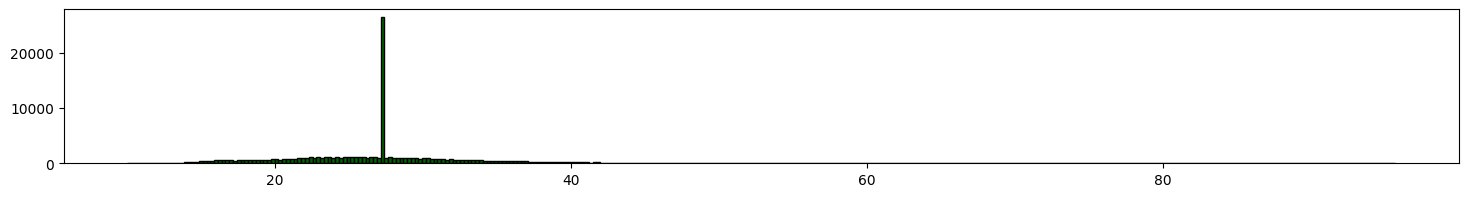

In [163]:
values = df['bmi']
counts, bins, _ = plt.hist(values, bins='auto', color='darkgreen', edgecolor='black')

plt.gcf().set_size_inches(18, 2)
plt.show()

That doesn't look good. I kept increasing the bins, before leaving them auto, but that singular peak will not disappear. Let's try logarithmic scale, so we can at least see something:

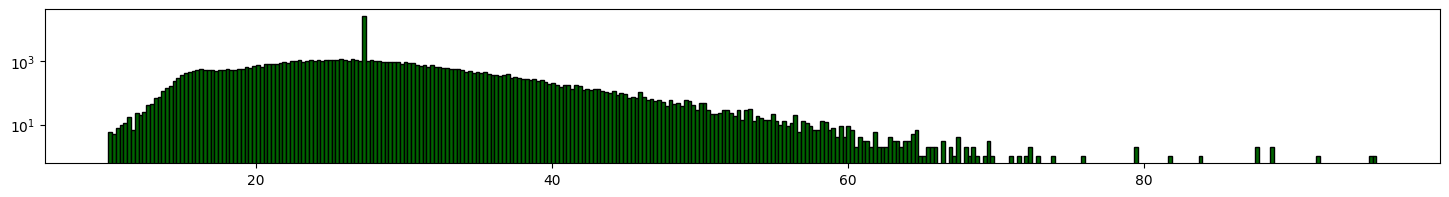

In [164]:
values = df['bmi']
counts, bins, _ = plt.hist(values, bins='auto', color='darkgreen', edgecolor='black')
plt.yscale('log')
plt.gcf().set_size_inches(18, 2)
plt.show()

Is that a single value of BMI? Let's count the most common values:

In [165]:
max_count_bin = np.argmax(counts)
max_count = counts[max_count_bin]
max_bin_range = (bins[max_count_bin], bins[max_count_bin + 1])

max_bin_range

unique_values, counts = np.unique(values, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
sorted_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

top_10_values = sorted_values[:10]
top_10_counts = sorted_counts[:10]

print(top_10_values)
print(top_10_counts)


[27.32 23.   27.12 27.8  24.96 22.4  25.   25.6  26.7  24.5 ]
[25495   103   101   100   100    99    99    98    94    94]


Yes, for some reason, we have over $\frac{1}{4}$ entries of the dataset with the exact BMI of 27.32. Let's look at these:

In [166]:
weird_entries = df[df['bmi'] == 27.32]

weird_entries.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
1,Female,54,False,False,no_info,27.32,6.6,80,False
2,Male,28,False,False,never,27.32,5.7,158,False
5,Female,20,False,False,never,27.32,6.6,85,False
9,Female,32,False,False,never,27.32,5.0,100,False
10,Female,53,False,False,never,27.32,6.1,85,False
14,Female,76,False,False,no_info,27.32,5.0,160,False
15,Male,78,False,False,no_info,27.32,6.6,126,False
18,Female,42,False,False,no_info,27.32,5.7,80,False
26,Male,67,False,True,not_current,27.32,6.5,200,True
38,Male,50,True,False,current,27.32,5.7,260,True


These all seem like real entries, not duplicates of the same entry. My best guess for what happened, is that when the BMI was missing, they put down the mean of the rest of the dataset, which is exactly `27.32`.

In [213]:
df[df['bmi'] != 27.32]['bmi'].mean()

27.364155519457587

In a real life scenario, I would clearify this with the person who gave me the data, however for this homework project, I will assume that when a person looks average weight, they may not bother measuring their BMI, so the average is probably a good approximation, so I will accept this.

Another concern I had was with extreme cases of BMI, such as the values 80 and above. I choose to keep these, because they are not overrepresented and diabetes is linked to extreme obesity, so these are important entry points for prediction.

### Age

Next issue is with the age.

Let's plot the values:

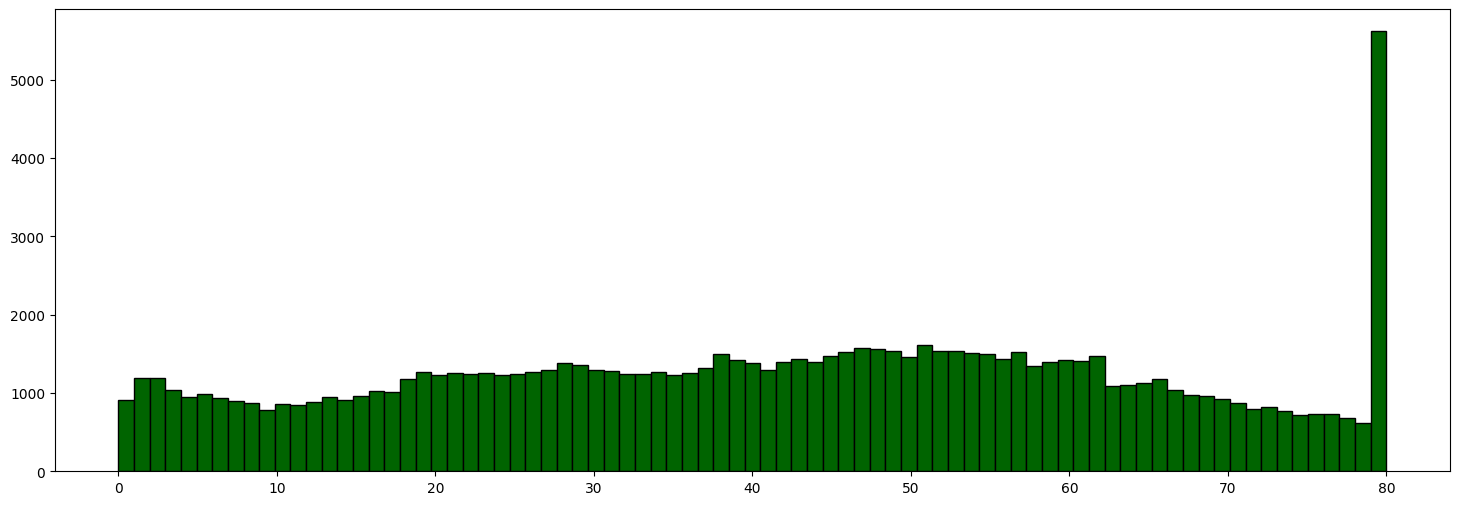

In [168]:
values = df['age']
num_bins = values.nunique()
counts, bins, _ = plt.hist(values, bins=num_bins, color='darkgreen', edgecolor='black')

plt.gcf().set_size_inches(18, 6)
plt.show()

We have a lot of people aged `80`. It looks like older people are overrepresented in this data and probably not all of them are exactly `80`, they just cut off the age to fit into a `[0,80]` interval.

In [169]:
df[df['age']==80]['age'].count()

5621

In this case, I choose to remove these values, because I feel like this could cause some skewing.

In [170]:
df = df[df['age'] < 80]

### Gender

Let's plot the values:

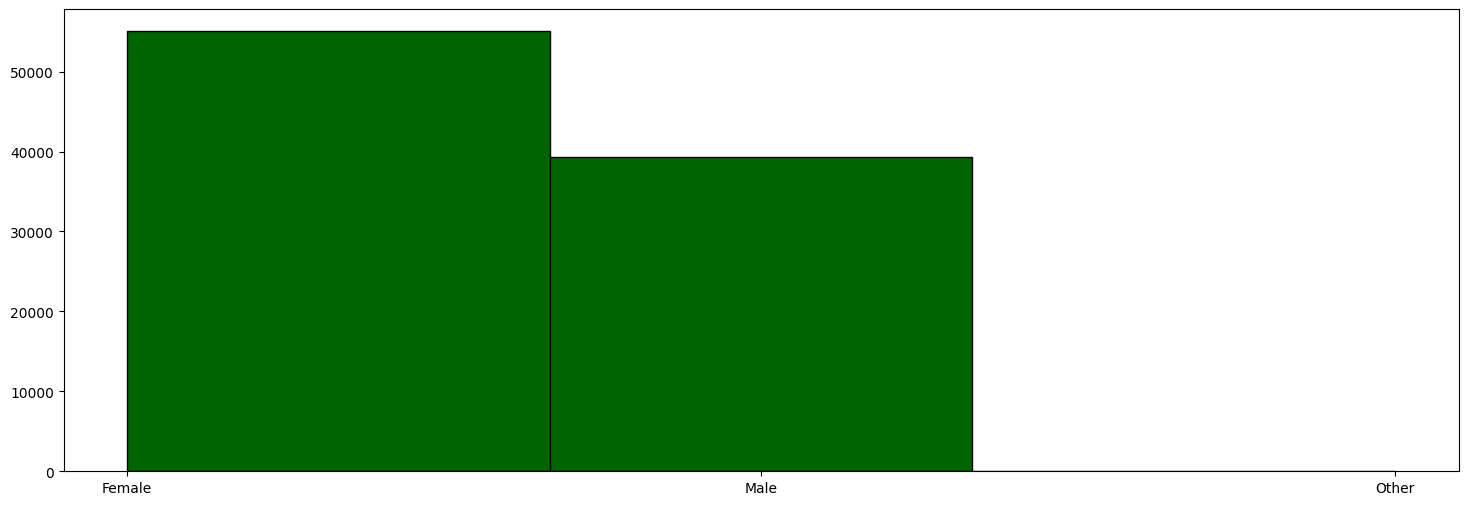

In [171]:
values = df['gender']
num_bins = values.nunique()
counts, bins, _ = plt.hist(values, bins=num_bins, color='darkgreen', edgecolor='black')

plt.gcf().set_size_inches(18, 6)
plt.show()

The category Other can mean many things. For medical research, we are concerned about the biological sex of the participants, so I will remove these entries too.

In [172]:
df = df[df['gender'] != 'Other']
df['gender'] = df['gender'].cat.remove_categories('Other')
df['gender'].unique()

['Female', 'Male']
Categories (2, object): ['Female', 'Male']

### Blood glucose level


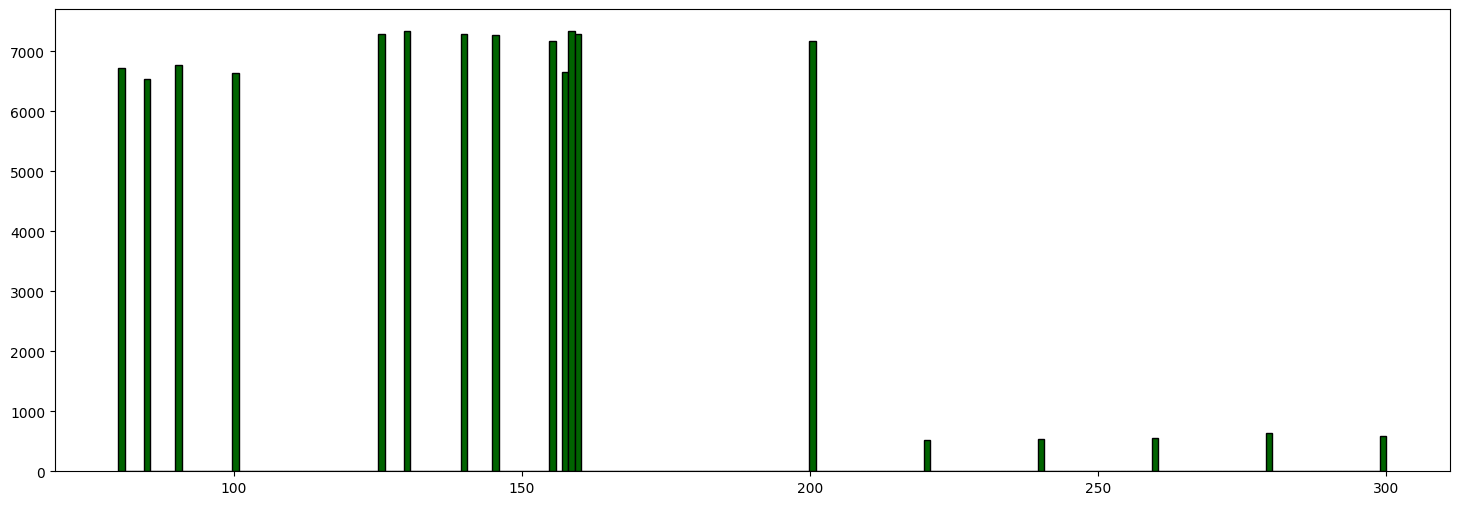

In [173]:
values = df['blood_glucose_level']
counts, bins, _ = plt.hist(values, bins=200, color='darkgreen', edgecolor='black')

plt.gcf().set_size_inches(18, 6)
plt.show()

It seems like this is not a continuous spectrum. There is also a concentration of values around 155-160. I'm not sure how to interpret this. The values are probably in mg/dl. For fasting levels, 80-100 is normal, 101-125 is elevated and above 126 is high. Other than that, I would need to ask someone with medical knowledge on why this is happening. For now, I have to accept these, as there is no clear way on how to fix them or if they need to be fixed at all.


### Blood sugar level

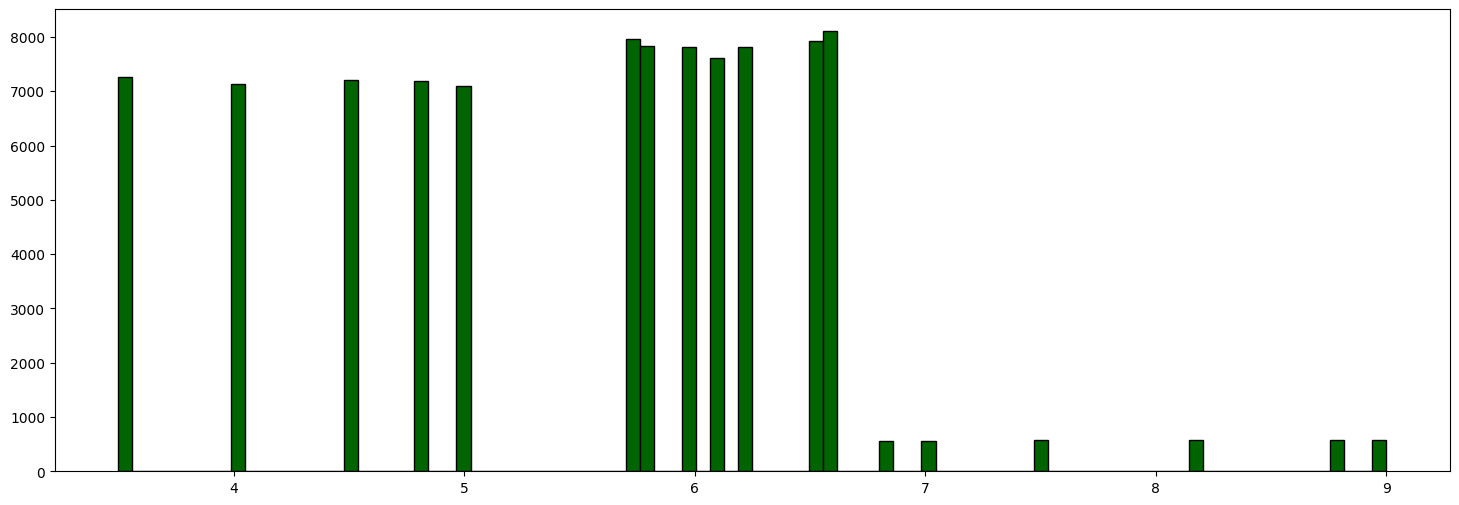

In [174]:
values = df['HbA1c_level']
counts, bins, _ = plt.hist(values, bins='auto', color='darkgreen', edgecolor='black')

plt.gcf().set_size_inches(18, 6)
plt.show()

For HbA1c, less than 5.6% is normal, between 5.7% - 6.4% is elevated (prediabetes) and above 6.5% is high (diabetes).

Although increasing the granuality does reveal that not every value is represented, but the precision is only one digit after the integer, so I think this looks okay.

### Smoking history

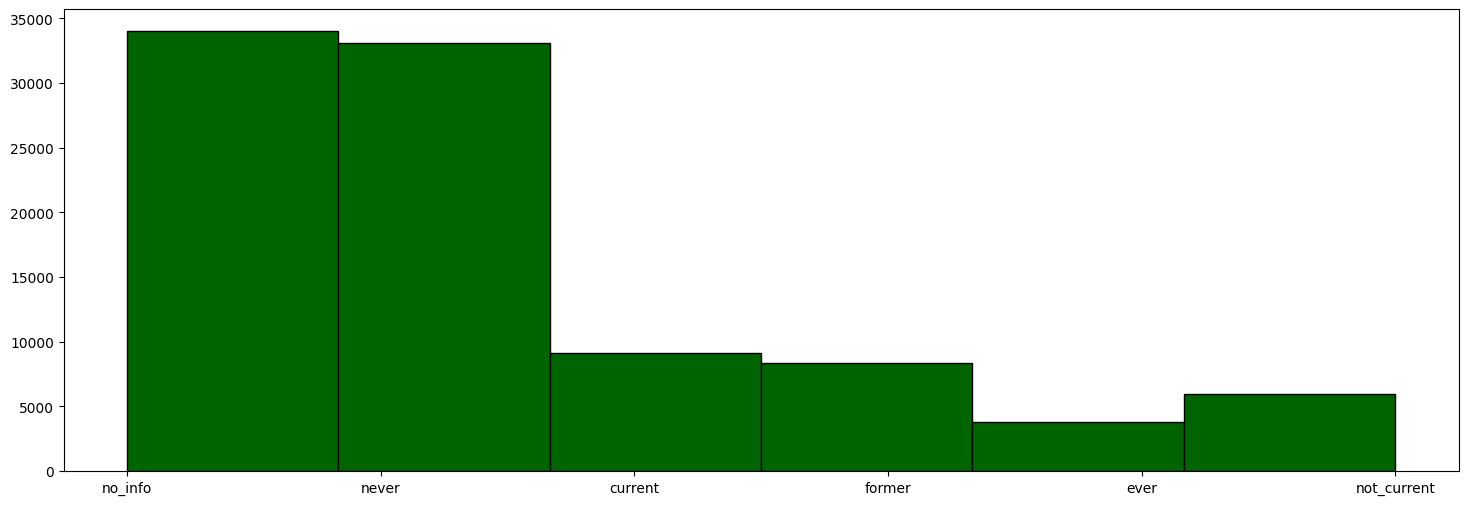

In [175]:
values = df['smoking_history']
num_bins = values.nunique()
counts, bins, _ = plt.hist(values, bins=num_bins, color='darkgreen', edgecolor='black')

plt.gcf().set_size_inches(18, 6)
plt.show()

We have a large amount of entries with `no_info` as a value. It might be worth removing these later, but I will keep them in for now, because they represent a large chunk of our data.

I was also questioning what `ever` means, given the other possibilities present, but I think it means they have tried smoking in the past, but weren't addicted.

### Hypertension

It seems like a reasonable distribution.

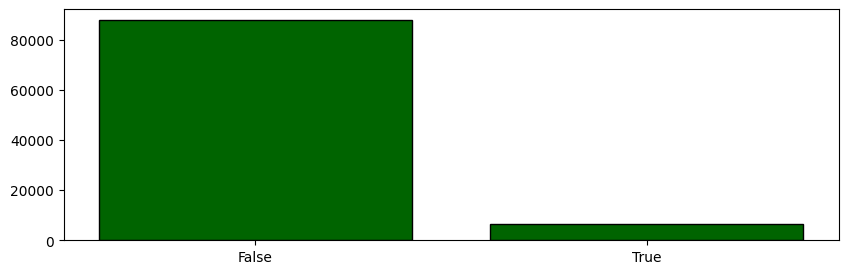

In [176]:
df['hypertension'].value_counts()

value_counts = df['hypertension'].value_counts()

# Plot
plt.figure(figsize=(10,3))
plt.bar(value_counts.index, value_counts.values, color='darkgreen', edgecolor='black')
plt.xticks(ticks=[0,1], labels=['False', 'True']) 
plt.show()

### Heart disease

Similarly, this looks okay.

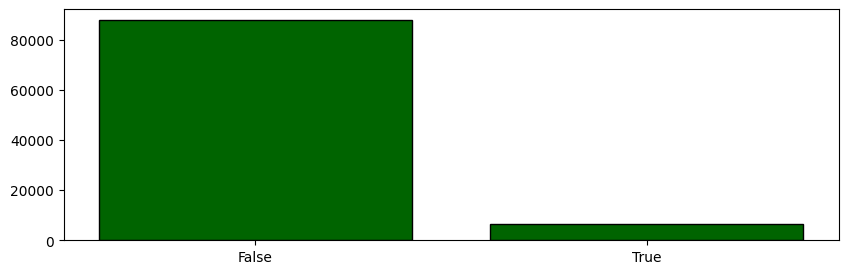

In [177]:
df['heart_disease'].value_counts()

value_counts = df['hypertension'].value_counts()

# Plot
plt.figure(figsize=(10,3))
plt.bar(value_counts.index, value_counts.values, color='darkgreen', edgecolor='black')
plt.xticks(ticks=[0,1], labels=['False', 'True']) 
plt.show()

### Diabetes

And our target value. This seems like a good ratio, similar to the generic population.

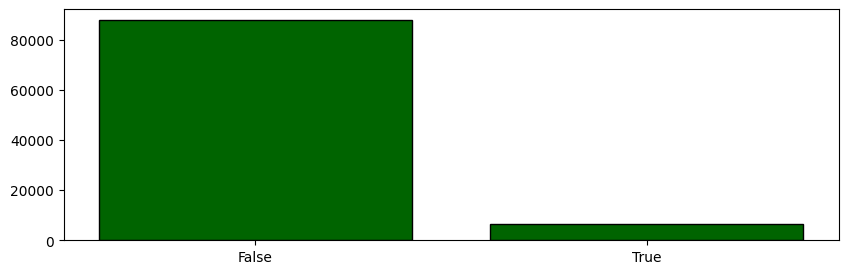

In [178]:
df['diabetes'].value_counts()

value_counts = df['hypertension'].value_counts()

# Plot
plt.figure(figsize=(10,3))
plt.bar(value_counts.index, value_counts.values, color='darkgreen', edgecolor='black')
plt.xticks(ticks=[0,1], labels=['False', 'True']) 
plt.show()

## Multivariate linear regression

The first thing I will try is create a multivariate linear regression model, using all of the available variables.

In order to do this, we must convert the categorical variables into 0/1 variables. This can be done with the `get_dummies` function, as seen below.

In [179]:
df_encoded = pd.get_dummies(df)
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,smoking_history_no_info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not_current
1,54,False,False,27.32,6.6,80,False,True,False,True,False,False,False,False,False
2,28,False,False,27.32,5.7,158,False,False,True,False,False,False,False,True,False
3,36,False,False,23.45,5.0,155,False,True,False,False,True,False,False,False,False
4,76,True,True,20.14,4.8,155,False,False,True,False,True,False,False,False,False
5,20,False,False,27.32,6.6,85,False,True,False,False,False,False,False,True,False


Then, we separate our target variable.

In [180]:
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']

And split the data into training and testing datasets, with the ratio of $80\%$ and $20\%$. It is good practice to seed the pseudorandom generator, so it will always result in the same split, across multiple runs of our notebook.

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Then we create our multivariate linear regression model, using `scikit-learn`.

In [182]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

The model's coefficients are as follows:

In [183]:
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_}).sort_values(by='Coefficient', ascending=False)
intercept = pd.DataFrame({'Variable': ['Intercept'], 'Coefficient': model.intercept_})

print("Coefficients:")
print(coefficients)
print("\nIntercept:")
print(intercept)

Coefficients:
                       Variable  Coefficient
2                 heart_disease     0.133472
1                  hypertension     0.103687
4                   HbA1c_level     0.076937
11       smoking_history_former     0.015804
7                   gender_Male     0.006450
3                           bmi     0.004050
5           blood_glucose_level     0.002163
13  smoking_history_not_current     0.001371
0                           age     0.001358
10         smoking_history_ever    -0.001578
9       smoking_history_current    -0.001865
12        smoking_history_never    -0.003399
6                 gender_Female    -0.006450
8       smoking_history_no_info    -0.010332

Intercept:
    Variable  Coefficient
0  Intercept    -0.814089


It is important to note here immediately, that the scale of these coefficients depends on their value sets. For example, gender_Male is between $0$ and $1$, while BMI is between $10$ and $100$. For this reason, we cannot compare the relative values of the coefficients, without taking into account the possible values of the variables behind them.

However, the signs (positive or negative) can be looked at and compared, which we will do shortly.

But first, the precision of this model on the test dataset is as follows:

In [184]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.04693052558568325


And on the train dataset:

In [214]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.048474640595590854


We can conclude, that the model was not overfit and the error is relatively low.

## Independence testing

### Gender

Examining the coefficients, the first thing I noticed is the `gender` variables. It seems that, with all other variables present, being male slightly increases, while being female slightly reduces the risk of diabetes.

I wonder if without the other variables, what could we say about the influence of gender on diabetes? I will test the independence of the `gender` and `diabetes` variables in the original dataset using Chi-square test of independence.

At first, I will create the frequency table of their values:

In [203]:
crosstab = pd.crosstab(df['gender'], df['diabetes'])
crosstab

diabetes,False,True
gender,,
Female,51188,3856
Male,35697,3620


Then, I will use `scipy`, to compute a Pearson's chi-squared statistic.

The null hypothesis is that the variables are independent.

In [204]:
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected:")
print(expected)

Chi-square value: 152.1271942474673
P-value: 5.94328803769177e-35
Degrees of freedom: 1
Expected:
[[50682.9933977  4361.0066023]
 [36202.0066023  3114.9933977]]


With a p-value of $p=5,94\cdot{}10^{-35}$ we can say, that we have very strong evidence against our null hypothesis, therefore we can conclude that gender and diabetes are indeed correlated with each other.

The gender of a person influences the likelihood of developing diabetes.

As we can see in the Expected matrix, that is the expected frequencies for the same population size, were these variables independent of each other. We can see that we got less than expected females with diabetes and more than expected males with diabetes.

### Smoking history

The other interesting thing I noticed about the multivariate linear regression coefficients is that `smoking_history_current` has a negative coefficient, while `smoking_history_former` and `smoking_history_not_current` have positive coefficients. At least `smoking_history_never` has a negative coefficient too, which makes perfect sense.

I do have tales from friends and family saying that when someone chooses to stop smoking is when the problems start. A more likely explanation is that when people stop smoking, the damage has already been done. When someone is still smoking, maybe they have less years behind them and quitting smoking **earlier** should help lower the risk of diabetes and heart disease (amongst many diseases).

In [215]:
crosstab = pd.crosstab(df['smoking_history'], df['diabetes'])
crosstab

diabetes,False,True
smoking_history,,
no_info,32751,1260
current,8227,924
ever,3376,436
former,7004,1372
never,30181,2878
not_current,5346,606


In [216]:
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected:")
print(expected)

Chi-square value: 1844.0298560488386
P-value: 0.0
Degrees of freedom: 5
Expected:
[[31316.38849737  2694.61150263]
 [ 8425.98780216   725.01219784]
 [ 3509.98420958   302.01579042]
 [ 7712.3892286    663.6107714 ]
 [30439.81321732  2619.18678268]
 [ 5480.43704497   471.56295503]]


In [217]:
crosstab = pd.crosstab(df['smoking_history'], df['diabetes'])
crosstab

diabetes,False,True
smoking_history,,
no_info,32751,1260
current,8227,924
ever,3376,436
former,7004,1372
never,30181,2878
not_current,5346,606


In [218]:
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected:")
print(expected)

Chi-square value: 1844.0298560488386
P-value: 0.0
Degrees of freedom: 5
Expected:
[[31316.38849737  2694.61150263]
 [ 8425.98780216   725.01219784]
 [ 3509.98420958   302.01579042]
 [ 7712.3892286    663.6107714 ]
 [30439.81321732  2619.18678268]
 [ 5480.43704497   471.56295503]]


The p-value is so small, the numerical representation cannot display it. This means smoking history has indeed a strong influence on whether or not someone develops diabetes.

I would like to further investigate this relationship. Since diabetes is a binary variable, it is hard to see exactly the effects of smoking on it. However, we have a few numerical variables in the dataset, which are strong indicators of diabetes, such as various measurements of blood levels and BMI.

So I will continue exploring the effects of smoking on these variables further.

## Correlation matrix

In order to establish which numerical variables have a strong relationship with diabetes, I will be using a correlation matrix heatmap to visualise these 1-1 relationships.

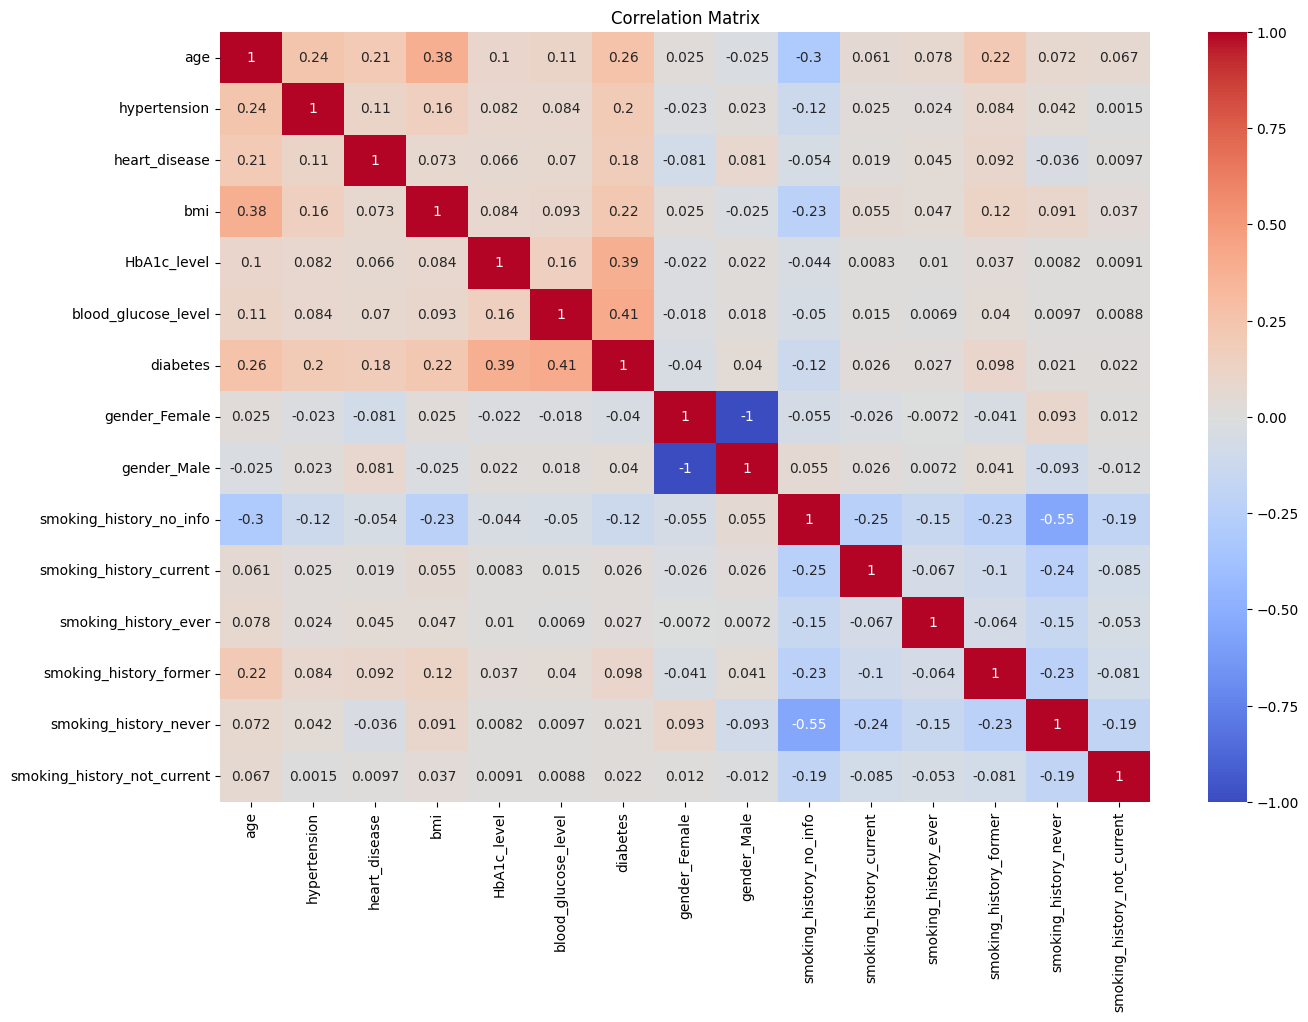

In [211]:
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix')
plt.show()

We can see on the heatmap, that `blood_glucose_level` and `HbA1c_level` have the strongest correlation to diabetes, so I will be exploring the effects of smoking on these variables.

## Testing the mean of categories

Smoking history is a categorical variable, which means it defines different groups of people. For these groups, I can calculate the mean of `blood_glucose_level` and `HbA1c_level`, then, I can investigate whether or not the differences in the results are statistically significant.

In [221]:
df.groupby('smoking_history')[['blood_glucose_level']].mean().sort_values('blood_glucose_level')

,blood_glucose_level
smoking_history,
no_info,135.019729
never,138.245107
ever,139.076600
not_current,139.088878
current,139.614905
former,142.896968


Here, we can see that the average blood glucose level slightly increases, as someone has more history with smoking. Interestingly again, current smokers rank below former smokers. This can again be due to the fact that former smokers may have a longer smoking history than current smokers.

In [222]:
df.groupby('smoking_history')[['HbA1c_level']].mean().sort_values('HbA1c_level')

,HbA1c_level
smoking_history,
no_info,5.457690
never,5.531640
current,5.546694
not_current,5.557023
ever,5.571800
former,5.646036


However, for `HbA1c_level`, the level of `ever`, which I assume means "smoked a bit a long time ago" seems really high on the ranking.